In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/darija-hate-speech-detection/test_data_cleaned.csv
/kaggle/input/darija-hate-speech-detection/df_without_Latin words.csv
/kaggle/input/darija-hate-speech-detection/df_without_spaces.csv
/kaggle/input/darija-hate-speech-detection/val_data_cleaned.csv
/kaggle/input/darija-hate-speech-detection/df_after_normalisation.csv
/kaggle/input/darija-hate-speech-detection/train.csv
/kaggle/input/darija-hate-speech-detection/test.csv
/kaggle/input/darija-hate-speech-detection/train_data_cleaned.csv


In [2]:
import pandas as pd

# Load datasets
train_data = pd.read_csv('/kaggle/input/darija-hate-speech-detection/train_data_cleaned.csv')
val_data = pd.read_csv('/kaggle/input/darija-hate-speech-detection/val_data_cleaned.csv')
test_data = pd.read_csv('/kaggle/input/darija-hate-speech-detection/test_data_cleaned.csv')

# Check the structure
print(train_data.head())

                                             comment  off
0                   شغلها هداك اتعري كاع راسها وتخرج    1
1  كتبقى مع كلب حيث ربما لقات الرحمة والرأفة فالح...    0
2                                     بنت نوال متوكل    0
3  شكون هي مها هي اصلا جرات ورا الفلوس عريانه اش ...    1
4  امشيتي الوطيل وماعرفش هادي غير بنت الكولية زعم...    0


In [4]:
train_data["comment"] = train_data["comment"].astype(str)
val_data["comment"] = val_data["comment"].astype(str)
test_data["comment"] = test_data["comment"].astype(str)

In [5]:
# Function to remove the longest sentence by character length
def remove_longest_sentence(data):
    # Add a length column
    data["length"] = data["comment"].apply(len)
    # Find the longest sentence
    longest_sentence_index = data["length"].idxmax()
    # Remove the longest sentence
    data = data.drop(longest_sentence_index).reset_index(drop=True)
    return data

# Apply to train, val, and test datasets
train_data = remove_longest_sentence(train_data)
val_data = remove_longest_sentence(val_data)
test_data = remove_longest_sentence(test_data)

In [6]:
train_data.shape


(5214, 3)

In [7]:
val_data.shape


(1202, 3)

In [8]:
test_data.shape


(1605, 3)

# This one

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn

# Load MARBERT tokenizer
MARBERT_tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")

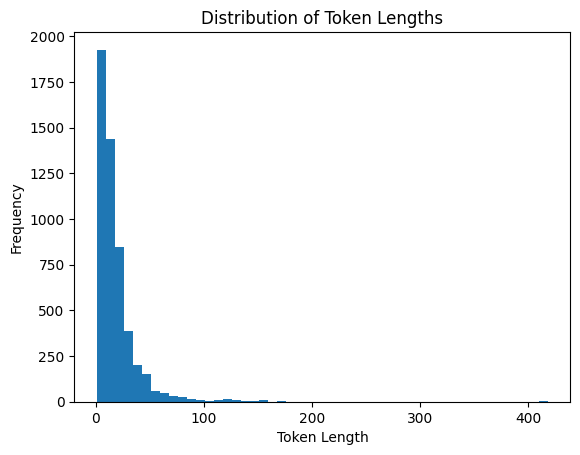

In [10]:
import matplotlib.pyplot as plt

token_lengths = train_data["comment"].apply(lambda x: len(MARBERT_tokenizer.tokenize(x)))
plt.hist(token_lengths, bins=50)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths")
plt.show()

In [11]:
print(token_lengths.quantile(0.95))  # 95th percentile


52.0


# Tokenizer

In [12]:
# Tokenize the datasets
def tokenize_data(data, max_length=128):
    return MARBERT_tokenizer(
        list(data["comment"]),  
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

# Tokenize the data
train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Custom Dataset class


In [13]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class
class SentenceDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert labels to tensors
train_labels = torch.tensor(train_data["off"].values)  
val_labels = torch.tensor(val_data["off"].values)
test_labels = torch.tensor(test_data["off"].values)

In [14]:
train_dataset = SentenceDataset(train_encodings, train_labels)
val_dataset = SentenceDataset(val_encodings, val_labels)
test_dataset = SentenceDataset(test_encodings, test_labels)

# Define the model


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define the MARBERT model and tokenizer
pretrained_model_name = "UBC-NLP/MARBERT"
MARBERT_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

# Load the original MARBERT model with a classification head
MARBERT_original_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels=2  # Binary classification
)

# Print model architecture to confirm
print(MARBERT_original_model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [16]:
from transformers import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define optimizer and loss function
optimizer = AdamW(MARBERT_original_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from tqdm import tqdm

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MARBERT_original_model.to(device)

# Initialize lists to track metrics and early stopping parameters
epoch_metrics = []
best_val_loss = float("inf")
best_model_path = "best_model.pth"

# Training loop
for epoch in range(5):  # Number of epochs
    # Training phase
    MARBERT_original_model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = MARBERT_original_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Extract the logits from the output object
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Store predictions and labels for metrics
        preds = torch.argmax(logits, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_precision = precision_score(all_train_labels, all_train_preds, average="binary")
    train_recall = recall_score(all_train_labels, all_train_preds, average="binary")
    train_f1 = f1_score(all_train_labels, all_train_preds, average="binary")

    # Validation phase
    MARBERT_original_model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = MARBERT_original_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract the logits from the output object
            loss = criterion(logits, labels)

            total_val_loss += loss.item()

            # Store predictions and labels for metrics
            preds = torch.argmax(logits, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds, average="binary")
    val_recall = recall_score(all_val_labels, all_val_preds, average="binary")
    val_f1 = f1_score(all_val_labels, all_val_preds, average="binary")

    # Save the best model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(MARBERT_original_model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}")

    # Store metrics for the epoch
    epoch_metric = {
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "train_precision": train_precision,
        "val_precision": val_precision,
        "train_recall": train_recall,
        "val_recall": val_recall,
        "train_f1": train_f1,
        "val_f1": val_f1,
    }
    epoch_metrics.append(epoch_metric)

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Train Accuracy: {train_accuracy:.4f} | Val Accuracy: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Val Precision: {val_precision:.4f}")
    print(f"  Train Recall: {train_recall:.4f} | Val Recall: {val_recall:.4f}")
    print(f"  Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

# Save all epoch metrics to a file
import json
with open("epoch_metrics.json", "w") as f:
    json.dump(epoch_metrics, f, indent=4)

print(f"Training completed. Best model saved to {best_model_path}")

100%|██████████| 163/163 [01:51<00:00,  1.47it/s]


Best model saved at epoch 1 with validation loss: 0.3530
Epoch 1:
  Train Loss: 0.4661 | Val Loss: 0.3530
  Train Accuracy: 0.7708 | Val Accuracy: 0.8469
  Train Precision: 0.7699 | Val Precision: 0.8797
  Train Recall: 0.8169 | Val Recall: 0.8279
  Train F1: 0.7927 | Val F1: 0.8530


100%|██████████| 163/163 [01:52<00:00,  1.45it/s]


Epoch 2:
  Train Loss: 0.2418 | Val Loss: 0.3637
  Train Accuracy: 0.8985 | Val Accuracy: 0.8411
  Train Precision: 0.9033 | Val Precision: 0.8955
  Train Recall: 0.9081 | Val Recall: 0.7969
  Train F1: 0.9057 | Val F1: 0.8433


100%|██████████| 163/163 [01:52<00:00,  1.45it/s]


Epoch 3:
  Train Loss: 0.1114 | Val Loss: 0.4783
  Train Accuracy: 0.9630 | Val Accuracy: 0.8453
  Train Precision: 0.9643 | Val Precision: 0.8592
  Train Recall: 0.9668 | Val Recall: 0.8512
  Train F1: 0.9655 | Val F1: 0.8551


100%|██████████| 163/163 [01:52<00:00,  1.45it/s]


Epoch 4:
  Train Loss: 0.0714 | Val Loss: 0.5950
  Train Accuracy: 0.9776 | Val Accuracy: 0.8344
  Train Precision: 0.9799 | Val Precision: 0.8858
  Train Recall: 0.9782 | Val Recall: 0.7938
  Train F1: 0.9791 | Val F1: 0.8373


100%|██████████| 163/163 [01:52<00:00,  1.45it/s]


Epoch 5:
  Train Loss: 0.0391 | Val Loss: 0.6264
  Train Accuracy: 0.9881 | Val Accuracy: 0.8519
  Train Precision: 0.9886 | Val Precision: 0.8772
  Train Recall: 0.9893 | Val Recall: 0.8419
  Train F1: 0.9889 | Val F1: 0.8592
Training completed. Best model saved to best_model.pth


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Get model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract logits
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Convert logits to predictions
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = total_loss / len(data_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="binary")
    recall = recall_score(all_labels, all_preds, average="binary")
    f1 = f1_score(all_labels, all_preds, average="binary")

    return {
        "loss": avg_loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Evaluate on training set
train_metrics = evaluate_model(MARBERT_original_model, train_loader, criterion, device)
print("Training Metrics:")
for key, value in train_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Evaluate on validation set
val_metrics = evaluate_model(MARBERT_original_model, val_loader, criterion, device)
print("\nValidation Metrics:")
for key, value in val_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")


Training Metrics:
Loss: 0.0167
Accuracy: 0.9942
Precision: 0.9968
Recall: 0.9925
F1: 0.9946

Validation Metrics:
Loss: 0.6264
Accuracy: 0.8519
Precision: 0.8772
Recall: 0.8419
F1: 0.8592


In [24]:
# Evaluate the model on the test dataset
test_metrics = evaluate_model(MARBERT_original_model, DataLoader(test_dataset, batch_size=32), criterion, device)

# Display the test metrics
print("Test Metrics:")
print(test_metrics)

Test Metrics:
{'loss': 0.6638594049339493, 'accuracy': 0.8411214953271028, 'precision': 0.8624401913875598, 'recall': 0.8373983739837398, 'f1': 0.8497348261638183}


In [25]:
def analyze_failures(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    misclassified_examples = []

    with torch.no_grad():  # Disable gradient calculations
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Get model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract logits

            # Convert logits to predictions
            preds = torch.argmax(logits, dim=1)

            # Find misclassified examples
            for i in range(len(labels)):
                if preds[i].item() != labels[i].item():  # Check for misclassification
                    misclassified_examples.append({
                        "text": MARBERT_tokenizer.decode(input_ids[i], skip_special_tokens=True),
                        "true_label": labels[i].item(),
                        "predicted_label": preds[i].item()
                    })

    return misclassified_examples

# Analyze misclassified examples in the test dataset
test_loader = DataLoader(test_dataset, batch_size=32)
misclassified_examples = analyze_failures(MARBERT_original_model, test_loader, device)

# Display the misclassified examples
print("\nMisclassified Examples:")
for example in misclassified_examples:
    print(f"Text: {example['text']}")
    print(f"True Label: {example['true_label']}, Predicted Label: {example['predicted_label']}")
    print("-" * 50)



Misclassified Examples:
Text: كل واحد حر في نفسه و شعب الميكروب
True Label: 1, Predicted Label: 0
--------------------------------------------------
Text: حسن الفاضك
True Label: 0, Predicted Label: 1
--------------------------------------------------
Text: هل اليوتوب اصبح مرحاض المعوقين
True Label: 1, Predicted Label: 0
--------------------------------------------------
Text: الراقصة والطبالةعايشة واله حتى قتلتنا بالضحك كلشى على الفتاحىغدى توصل بالحلال ان شاء اله
True Label: 0, Predicted Label: 1
--------------------------------------------------
Text: ليدار لهاد الفيديو ايدير لايك كومنتير
True Label: 1, Predicted Label: 0
--------------------------------------------------
Text: عايلتها مساكن اله يكون في عوانهم بقاو فيا مساكن اله ياخذ الحق في هذا شوها
True Label: 0, Predicted Label: 1
--------------------------------------------------
Text: اتقوا اله ربنادم لي خايب خارج على طريق لبنات ولا دراري لحمل مجاش من سما غلط ديالهم مجوج اش دنب دراري وهاديك لمراة لي مزوج بها رشيد مشي ضيعها ميسته

# New exemples


In [30]:
def test_model_on_generated_examples(model, tokenizer, generated_examples, max_length=128):
    """
    Test the model on a list of generated examples and display predictions.

    Args:
        model (torch.nn.Module): The trained model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for input text.
        generated_examples (list): List of input comments to test.
        max_length (int): Maximum token length for padding/truncation.

    Returns:
        None
    """
    # Set the model to evaluation mode
    model.eval()

    # Iterate through the generated examples
    for idx, comment in enumerate(generated_examples):
        # Tokenize the input comment
        inputs = tokenizer(
            comment,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        # Move inputs to the device
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits  # Extract logits

        # Get the predicted class
        predicted_class = torch.argmax(logits, dim=1).item()
        label = "Non-Offensive" if predicted_class == 0 else "Offensive"

        # Print results
        print(f"Example {idx + 1}:")
        print(f"Comment: {comment}")
        print(f"Predicted Label: {predicted_class} ({label})\n")
        print("-" * 50)


In [31]:
# List of generated examples
generated_examples = [
    "هذا غير كلام عادي ومافيه والو",  # Non-offensive
    "واش نتا مكلخ ولا شنو؟",  # Offensive
    "شكرا بزاف على مساعدتك",  # Non-offensive
    "نتا واحد الحمار بلا بلا بلا",  # Offensive
    "الله يعاونك وصافي",  # Non-offensive
    "سير فحالك انت واحد المكلخ",  # Offensive
    "شكرا بزاف خدمتك زوينة",  # Non-offensive
    "كلامك كامل زبل وغير مقبول",  # Offensive
    "تبارك الله عليك خدمتك واعرة",  # Non-offensive
    "هضرتك راه قلة الحيا وقلة الاحترام",  # Offensive
    "زوج ديوتي العفة ماتغير المغرب",  # Offensive
]

# Test the model on the examples
test_model_on_generated_examples(MARBERT_original_model, MARBERT_tokenizer, generated_examples)

Example 1:
Comment: هذا غير كلام عادي ومافيه والو
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 2:
Comment: واش نتا مكلخ ولا شنو؟
Predicted Label: 1 (Offensive)

--------------------------------------------------
Example 3:
Comment: شكرا بزاف على مساعدتك
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 4:
Comment: نتا واحد الحمار بلا بلا بلا
Predicted Label: 1 (Offensive)

--------------------------------------------------
Example 5:
Comment: الله يعاونك وصافي
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 6:
Comment: سير فحالك انت واحد المكلخ
Predicted Label: 1 (Offensive)

--------------------------------------------------
Example 7:
Comment: شكرا بزاف خدمتك زوينة
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 8:
Comment: كلامك كامل زبل وغير مقبول
Predicted Label: 1 (Offensive)

-----------------

In [32]:
generated_examples = [
    # Non-Offensive Comments (0)
    "شكرا بزاف على مساعدتك",  
    "الله يعاونك وصافي",  
    "شكرا بزاف خدمتك زوينة",  
    "تبارك الله عليك خدمتك واعرة",  
    "الله يرحم والديك على هاد الخدمة",  
    "بغيت نسولك على واحد القضية، واش ممكن؟",  
    "نهاركم مبارك وتكون عندكم أيام زوينة",  
    "الحياة جميلة وما خاصنا غير شوية صبر",  
    "أنا فرحان بزاف بهاد النتيجة",  
    "راك داير مجهود كبير، تبارك الله عليك",  
    "ربي يوفقك فدراستك",  
    "خدمتك غزالة وتستاهل كل خير",  
    "الابتسامة ديالك تنور الدنيا",  
    "ممكن تعاونني في هاد الموضوع الله يجازيك بخير",

    # Offensive Comments (1) - Sexual Hate
    "نتي غير وحدة خايبة وسافلة وما فيك لا حياء لا عفة",  
    "بزاف عليك كلمة محترمة، راك غير وحدة رخيصة",  
    "نتي غير وحدة دايرة اللي بغات وكتبيع شرفها",  
    "راك بحال ديك اللي كيمشيو الكاباريهات بلا حياء",  
    "كتبان محترمة ولكن في الحقيقة ما عندك لا دين لا عفة",  
    "هادي غير وحدة ديال الزنقة وكتبان بالوجه ديالها",  
    "راه عايشة حياتها غير في الفساد والعيب",  
    "نتي دايرة بحال ديك لي كتخدم ليل نهار في البار",  
    "كتضحكي على الناس ولكن الحقيقة معروفة على شرفك",  
    "هذاك راه عايش حياتو غير في الكباريات وكيشوه سمعته",  
    "نتي غير وحدة دايرة طريق المعيشة بلا شرف",  
    "كيبان عليهم غير ديال الزنقة وكيقلبو على الحرام",  
    "نتي بحال وحدة معروفة بالخيانة والفساد في الحومة",  
    "هاد الشخص كيبيع راسو باش يعيش حياتو",  
    "ما عندهاش احترام ولا أخلاق غير دايرة لي بغات",  
    "كتبيع كلام العيب والناس كيعرفوك ديال الزنقة",  
    "راهم عايشين حياتهم كلها في الحرام والفساد",  
    "كتدير لي بغات بلا حياء ولا احترام لنفسها ولا لآخرين"
]

    
# Test the model on the examples
test_model_on_generated_examples(MARBERT_original_model, MARBERT_tokenizer, generated_examples)

Example 1:
Comment: شكرا بزاف على مساعدتك
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 2:
Comment: الله يعاونك وصافي
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 3:
Comment: شكرا بزاف خدمتك زوينة
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 4:
Comment: تبارك الله عليك خدمتك واعرة
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 5:
Comment: الله يرحم والديك على هاد الخدمة
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 6:
Comment: بغيت نسولك على واحد القضية، واش ممكن؟
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 7:
Comment: نهاركم مبارك وتكون عندكم أيام زوينة
Predicted Label: 0 (Non-Offensive)

--------------------------------------------------
Example 8:
Comment: الحياة جميلة وما خاصنا غير شوية صبر

In [33]:
import shutil

# Define the source directory and output file
model_save_path = "./fine_tuned_marbert_without_Dense_layer"
output_file = "./fine_tuned_marbert_without_Dense_layer.zip"

# Compress the directory into a ZIP file
shutil.make_archive("fine_tuned_marbert_without_Dense_layer", 'zip', model_save_path)

print(f"Model compressed and saved as {output_file}")

Model compressed and saved as ./fine_tuned_marbert_without_Dense_layer.zip


In [34]:
import os
import torch

# Define save path
save_directory = "./marbert_finetuned_model"

# Create directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the best model's state dictionary
best_model_path = os.path.join(save_directory, "pytorch_model.bin")
torch.save(MARBERT_original_model.state_dict(), best_model_path)

# Save the tokenizer
tokenizer_directory = os.path.join(save_directory, "tokenizer")
MARBERT_tokenizer.save_pretrained(tokenizer_directory)

# Save the model configuration
config_path = os.path.join(save_directory, "config.json")
with open(config_path, "w") as f:
    f.write(MARBERT_original_model.bert.config.to_json_string())

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to ./marbert_finetuned_model


In [36]:
import shutil

# Define the save directory and the zip file name
save_directory = "./marbert_finetuned_model"
zip_file_name = "marbert_finetuned_model.zip"

# Compress the directory into a zip file
shutil.make_archive(save_directory, 'zip', save_directory)

# Download the zip file to your local system
from google.colab import files
files.download(zip_file_name)

print(f"{zip_file_name} is ready for download.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

marbert_finetuned_model.zip is ready for download.


In [37]:
import shutil
from IPython.display import HTML

# Define the save directory and the zip file name
save_directory = "./marbert_finetuned_model"
zip_file_name = "marbert_finetuned_model.zip"

# Compress the directory into a zip file
shutil.make_archive(save_directory, 'zip', save_directory)

# Generate a download link
def create_download_link(file_name):
    return HTML(f'<a href="{file_name}" download>{file_name}</a>')

# Display the download link
print(f"{zip_file_name} is ready for download.")
create_download_link(zip_file_name)


marbert_finetuned_model.zip is ready for download.
